In [1]:
#Importing required libraries
import os
import cv2
import glob
import numpy as np
import pandas as pd
import random
import sys
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#Defining seed function
def setSeeds(seed=42):
    np.random.seed(seed)

In [3]:
#number of epochs that training should happen
image_size = 32
num_steps=15000
num_channels = 3
image_size_flat = image_size * image_size * num_channels
image_shape = (image_size, image_size)

trainpath='./data/train'
testpath='./data/test'
labels = {'cats': 0, 'dogs': 1}
fc_size=32 #size of the output of final FC layer
setSeeds()

In [4]:
#Reading images
def read_images_classes(basepath,imgSize=image_size):
    image_stack = []
    label_stack = []
    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,image_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])
    return np.array(image_stack), np.array(label_stack)

length of train image set 40
X_data shape: (40, 32, 32, 3)
y_data shape: (40,)


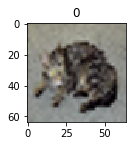

In [9]:
#Training and testing split
X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)
#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)
fig1 = plt.figure()
ax1 = fig1.add_subplot(2,2,1)
img = cv2.resize(X_train[10],(64,64), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[10])
plt.show()

In [6]:
#Building, compiling and evaluating the model
def cnn_model_fn(features, labels, mode):
    #Input layer
    input_layer = tf.reshape(features['x'], 
                             [-1, image_size, image_size, num_channels])
    #convolution layer
    #Convolutional layer 1 with 32 filters of kernel size[5,5] 
    convolution1 = tf.compat.v1.layers.conv2d( inputs = input_layer, filters=32, 
                                   kernel_size=[5,5], padding='same', activation=tf.nn.relu)
    pool1 = tf.compat.v1.layers.max_pooling2d(inputs=convolution1, 
                                    pool_size=[2,2], strides=2)
    #convolution layer2
    #Convolutional layer 2 with 64 filters of kernel size[5,5] 
    convolution2 = tf.compat.v1.layers.conv2d( inputs = input_layer, filters=64, 
                                   kernel_size=[5,5], padding='same', activation=tf.nn.relu)
                                              
    #pooling layer 2 , reduce the data size by 1/4th , each dim by half
    pool2 = tf.compat.v1.layers.max_pooling2d(inputs=convolution2, 
                                    pool_size=[2,2], strides=2)
    
    #flatten the layer
    layer_shape = pool2.get_shape()
    num_features = layer_shape[1:4].num_elements()
    pool2_flat = tf.reshape(pool2, [-1,num_features])
    
    #fully connected layer
    dense = tf.compat.v1.layers.dense(inputs=pool2_flat, units = fc_size, 
                            activation=tf.nn.relu)
                                              
    dropout = tf.compat.v1.layers.dropout(inputs = dense, rate =0.4, 
                            training= (mode==tf.estimator.ModeKeys.TRAIN))
    #Logits , decison making layer
    logits = tf.compat.v1.layers.dense(inputs=dropout, units = 2)
    
    #define predictions
    predictions = {'classes': tf.argmax(input=logits, axis =1),
                   'probabilities': tf.nn.softmax(logits, name ='softmax_tensor')}
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
                                              
    #calculate loss
    hot_labels = tf.one_hot(indices = tf.cast(labels,tf.int32), depth=2)
    loss = tf.compat.v1.losses.softmax_cross_entropy(onehot_labels=hot_labels,
                                           logits = logits  )
    
    #training operation
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(loss=loss,
                                      global_step=tf.compat.v1.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, 
                                          loss =loss, train_op=train_op)
                                              
    #Eval mode
    eval_metric_ops ={'accuracy': tf.compat.v1.metrics.accuracy(labels=labels, 
                                        predictions=predictions['classes'])}
    return tf.estimator.EstimatorSpec(mode=mode, 
                                          loss =loss, 
                                      eval_metric_ops=eval_metric_ops)

In [7]:
#Running and Finding accuracy of the model
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
X_train = np.array((X_train/255.0),dtype=np.float32)
X_test = np.array((X_test/255.0), dtype=np.float32)
pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/pets_convnet_model")
#pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.estimator.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=10,
                                                      num_epochs=None, shuffle=True)

pets_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])
eval_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(x={"x": X_test}, y=y_test, num_epochs=1,shuffle=False)
eval_results = pets_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

I0225 13:48:11.346874 140294865721088 estimator.py:1800] Using default config.
I0225 13:48:11.347829 140294865721088 estimator.py:212] Using config: {'_model_dir': '/tmp/pets_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9897d42978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas'

{'accuracy': 0.65, 'loss': 2.9204679, 'global_step': 15000}
